In [1]:
%matplotlib inline
import numpy
import pandas
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import os, sys
sys.path.append('../code')

from retina_double import *

/home/oalenkin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pandas.read_csv('../data/hits.csv', index_col=0)

In [4]:
from sklearn.cross_validation import train_test_split

event_ids = numpy.unique(data.EventID.values)
event_ids_train, event_ids_test= train_test_split(event_ids, train_size=100, random_state=42)
#event_ids_train, event_ids_valid = train_test_split(event_ids_train, train_size=0.5, random_state=42)

print len(event_ids_train)

100


# Train Classifier for the Tracks Combination

In [5]:
from combination import Combinator, SuperCombinator
from metrics import TracksReconstractionMetrics, CombinatorQuality

In [6]:
def merge_dicts(dict_args):
    '''
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    '''
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

In [7]:
%%time

from combination import SuperCombinator
from multiprocessing import Pool

event_ids = event_ids_train
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    # Tracks reconstruction before the magnet
    tr2d12 = RetinaTrackReconstruction(sigma_from=0.8, sigma_to=0.4, pre_sigma=0.4, stopping_criteria=0.00001, inlier_treshold=0.45)
    tr2d12.fit(event12[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values, event12.dist2Wire.values)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Tracks reconstruction after the magnet
    tr2d34 = RetinaTrackReconstruction(sigma_from=0.8, sigma_to=0.4, pre_sigma=0.4, stopping_criteria=0.00001, inlier_treshold=0.45)
    tr2d34.fit(event34[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values, event34.dist2Wire.values)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    
    return one_track

if __name__ == "__main__":
    p = Pool(4)
    results = p.map(tracks_reconstruction, event_ids)
    tracks = merge_dicts(results)

CPU times: user 184 ms, sys: 48 ms, total: 232 ms
Wall time: 6min 39s


In [8]:
sc = SuperCombinator()

combination_data = sc.data_collection(tracks, data)

X_data = combination_data[combination_data.columns[:-1]].values
y_data = combination_data.label.values

In [9]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

#xgb_base = GradientBoostingClassifier()
xgb_base = XGBClassifier(n_estimators=1000, nthread=3, 
                             subsample=0.7, max_depth=8)
#xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=3, 
#                             subsample=0.7, max_depth=8)
folding = FoldingClassifier(xgb_base, n_folds=10, random_state=11)
%time folding.fit(X_data, y_data)

CPU times: user 2.06 s, sys: 16 ms, total: 2.08 s
Wall time: 712 ms


FoldingClassifier(base_estimator=XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=1000, nthread=3, objective='binary:logistic', seed=0,
       silent=True, subsample=0.7),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14'],
         n_folds=10, parallel_profile=None, random_state=11)

KFold prediction using folds column
KFold prediction using folds column
0.989999749994


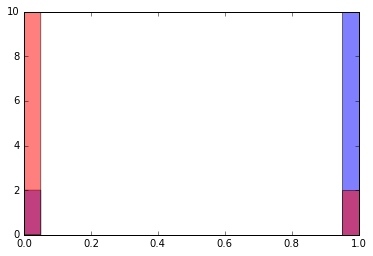

In [10]:
y_proba = folding.predict_proba(X_data)[:, 1]
y_predict = folding.predict(X_data)

y_proba = y_predict

from sklearn.metrics import roc_auc_score
print roc_auc_score(y_data, y_proba)

plt.hist(y_proba[y_data==1], label='1', color='b', bins=20, alpha=0.5)
plt.hist(y_proba[y_data==0], label='0', color='r', bins=20, alpha=0.5)
plt.ylim(0,10)
plt.show()

In [11]:
N = ((y_predict == y_data)*1).sum()
N_mis = ((y_predict != y_data)*1).sum()

print N, N_mis

396 4


# Tracks reconstruction

In [12]:
%%time
event_ids = event_ids_test

tracks = {}
tracks_comb = {}

tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['RecoEvents', 'Y12', 'Y34', 'Combination', 'Matching'])

for event_id in event_ids:
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    # Tracks reconstruction before the magnet
    tr2d12 = RetinaTrackReconstruction(sigma_from=0.8, sigma_to=0.4, pre_sigma=0.4, stopping_criteria=0.00001, inlier_treshold=0.45)
    tr2d12.fit(event12[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values, event12.dist2Wire.values)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2)
    trm12.fit(labels12, event12)
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    tr2d34 = RetinaTrackReconstruction(sigma_from=0.8, sigma_to=0.4, pre_sigma=0.4, stopping_criteria=0.00001, inlier_treshold=0.45)
    tr2d34.fit(event34[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values, event34.dist2Wire.values)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
    
    # Save the reconstructed tracks
    tracks[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                        'labels34':labels34, 'params34':tracks_params34}
    
    
    # Combination of the tracks before and after the magnet
    comb = SuperCombinator(classifier=folding.estimators[0])
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
    
    # Quality of the combination

    cq = CombinatorQuality()
    cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)

    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]

    for num in range(len(cq.check_tracks_combinations_)):

        combinations_true.loc[len(combinations_quality)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]



    # Overall quality
    pass_stages.loc[len(pass_stages)] = numpy.array([1, 
                                                     (trm12.recognition_efficiency_ == 1)*1,
                                                     (trm34.recognition_efficiency_ == 1)*1, 
                                                     (cq.n_combined_ >= 2)*1,
                                                     (cq.reco_eff_ == 1)*1]).cumprod()

    if not (trm12.recognition_efficiency_ == 1):
        print 1, event_id
    elif not (trm34.recognition_efficiency_ == 1):
        print 2, event_id
    elif not (cq.n_combined_ >= 2):
        print 3, event_id



    # Save the tracks combination
    tracks_comb[event_id] = {'tracks_combinations':comb.tracks_combinations_, 
                             'charges':comb.charges_, 
                             'inv_momentums':comb.inv_momentums_}

3 670
3 2040
2 1722
1 1848
1 3607
3 4439
2 916
1 2762
3 143
2 4490
3 3406
3 270
3 1528
3 1756
3 3781
CPU times: user 57min 25s, sys: 30.6 s, total: 57min 55s
Wall time: 51min 34s


# Quality

# Stations 1&2

## track efficiency

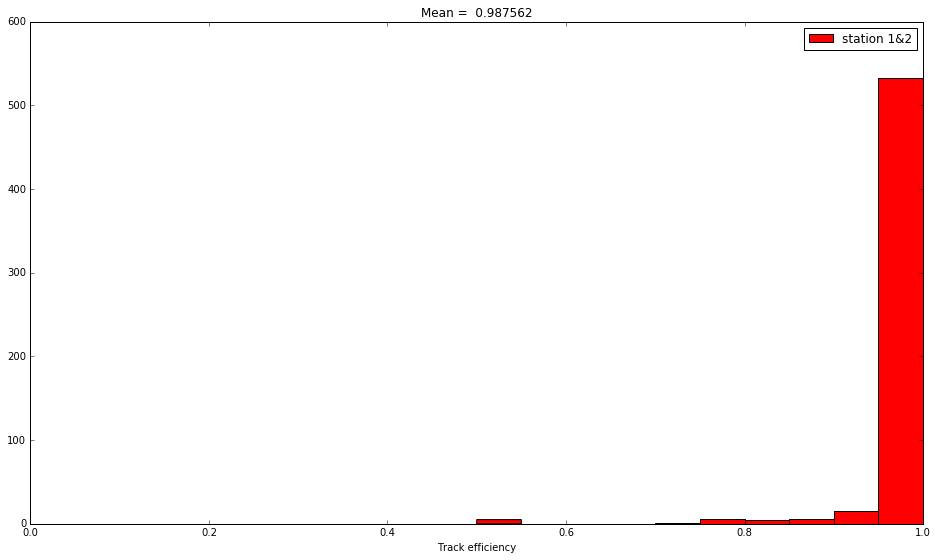

In [13]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

## reconstruction efficiency

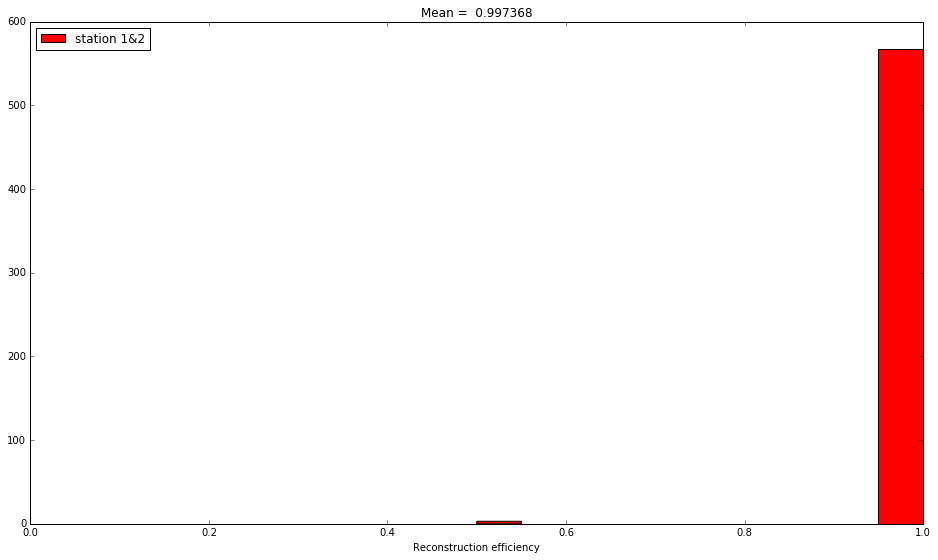

In [14]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

## track efficiency

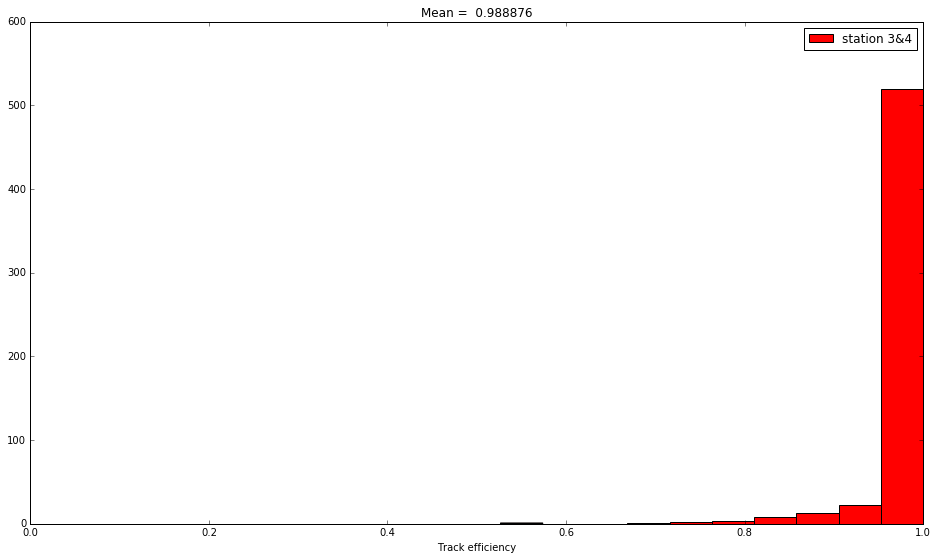

In [15]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

## reconstruction efficiency

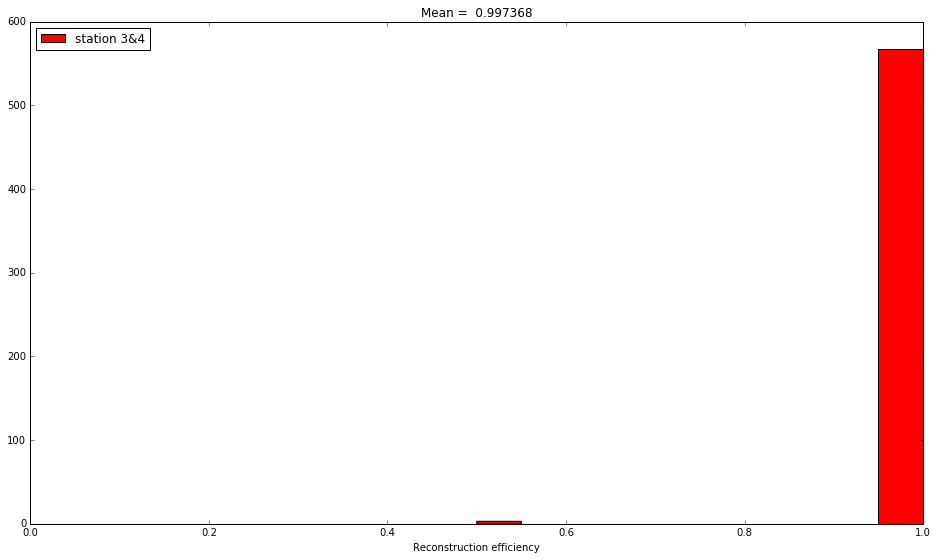

In [16]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

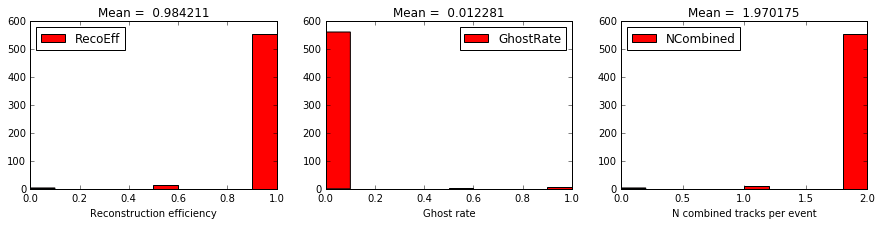

In [17]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

97.3684210526


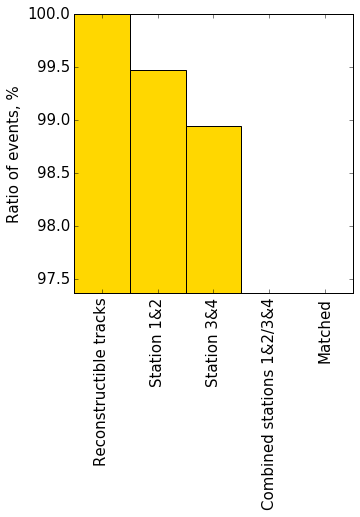

In [18]:
bar_labels = ['Reconstructible tracks', 
              'Station 1&2',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages.sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(5,5))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, size=15)
plt.yticks(size=15)
plt.xlim(-0.5, 4.5)
plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=15)
plt.show()

# Momentum

In [19]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

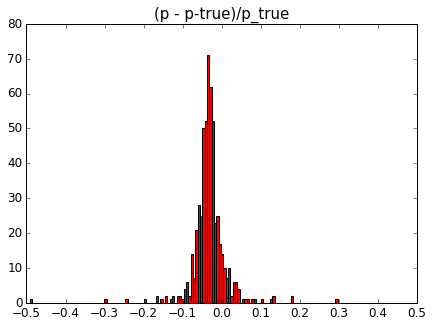

In [20]:
plt.figure(figsize=(7, 5))
plt.hist(p_err[~np.isnan(p_err)], bins=500)

plt.title('(p - p-true)/p_true', size=15)
plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim(-0.5, 0.5)
plt.show()